In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pipelines.processing.processing_steps.data_augmentation_copy import OptimizedDataAugmentation
from tqdm import tqdm
import os
from pathlib import Path
SPECTRAL_BANDS = ["b2", "b3", "b4", "b5", "b6", "b7", "b8", "b8a", "b11", "b12"]

In [2]:
df_trees_raw = pd.read_csv("../../data/raw/raw_trainset.csv")
df = df_trees_raw.copy()
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values(by=["id", "time"]).reset_index(drop=True).sample(frac=0.01)
df["month"] = df["time"].dt.month

Training: 100%|███████████████████████████████████████████████████| 144/144 [00:40<00:00,  3.53it/s]


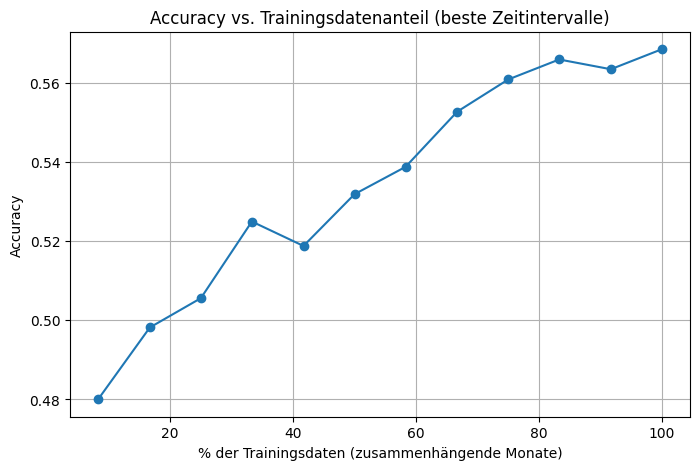

Ergebnisse:
8.3% Daten → Accuracy = 0.480 → Monate: [3]
16.7% Daten → Accuracy = 0.498 → Monate: [2, 3]
25.0% Daten → Accuracy = 0.506 → Monate: [9, 10, 11]
33.3% Daten → Accuracy = 0.525 → Monate: [2, 3, 4, 5]
41.7% Daten → Accuracy = 0.519 → Monate: [1, 2, 3, 4, 5]
50.0% Daten → Accuracy = 0.532 → Monate: [1, 2, 3, 4, 5, 6]
58.3% Daten → Accuracy = 0.539 → Monate: [12, 1, 2, 3, 4, 5, 6]
66.7% Daten → Accuracy = 0.553 → Monate: [8, 9, 10, 11, 12, 1, 2, 3]
75.0% Daten → Accuracy = 0.561 → Monate: [10, 11, 12, 1, 2, 3, 4, 5, 6]
83.3% Daten → Accuracy = 0.566 → Monate: [8, 9, 10, 11, 12, 1, 2, 3, 4, 5]
91.7% Daten → Accuracy = 0.563 → Monate: [6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4]
100.0% Daten → Accuracy = 0.569 → Monate: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [ ]:
def train_and_score(train_df, test_df):
    X_train = train_df.drop(columns=["species", "time", "month", "id", "disturbance_year", "doy"])
    y_train = train_df["species"]
    X_test = test_df.drop(columns=["species", "time", "month", "id", "disturbance_year", "doy"])
    y_test = test_df["species"]

    model = RandomForestClassifier(n_estimators=15, n_jobs=8, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

def get_interval_months(start, length):
    return [(start + i - 1) % 12 + 1 for i in range(length)]


months = [df[df["month"] == m] for m in range(1, 13)]
all_unique_ids = df["id"].unique()
rng = np.random.default_rng(42)
rng.shuffle(all_unique_ids) 
test_ratio = 0.2
num_test = max(1, int(test_ratio * len(all_unique_ids))) 
global_test_ids = all_unique_ids[:num_test] 
global_test_df = df[df["id"].isin(global_test_ids)].copy() 
df_train_pool = df[~df["id"].isin(global_test_ids)].copy()
df_train_pool["month"] = df_train_pool.time.dt.month
results = {}
intervals = {}
total_steps = 12 * 12 

with tqdm(total=total_steps, desc="Training", ncols=100) as pbar:
    for length in range(1, 13): 
        best_acc = -1
        best_months = None
        
        for start in range(1, 13):
            months_in_interval = get_interval_months(start, length)
            months_to_train_on = [m for m in months_in_interval]
            train_df = df_train_pool[df_train_pool["month"].isin(months_to_train_on)]
        
            test_df = global_test_df
            if train_df.empty:
                acc = 0.0 
            else:
                acc = train_and_score(train_df, test_df)

            if acc > best_acc:
                best_acc = acc
                best_months = months_in_interval
            
            pbar.update(1)

        percent = length / 12 * 100
        results[round(percent, 1)] = best_acc
        intervals[round(percent, 1)] = best_months

x, y = zip(*sorted(results.items()))
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o')
plt.xlabel('% of Training Data (zusammenhängende Monate)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Training data intervals ')
plt.grid(True)
plt.show()


print("Ergebnisse:")
for p, acc in results.items():
    mons = intervals[p]
    print(f"{p}% Daten → Accuracy = {acc:.3f} → Monate: {mons}")